In [1]:
from BPTK_Py import Model, bptk
from pygments.lexers import resource

#https://bptk.transentis.com/tutorials/system_dynamics/sd_tutorial.html
#https://bptk.transentis.com/quickstart/quickstart.html
#https://medium.com/@shouke.wei/python-system-dynamics-from-vensim-diagrams-to-running-code-in-minutes-4769a48f389d

# LE 2: Systemdynamiksimulationen

In [2]:
# 1) Model initialization

model = Model(
    starttime=0.0,
    stoptime=20.0,
    dt=1.0,
    name="Ants"
)

In [3]:
# 2) Stocks + initial values

ant_colonies = model.stock("Ameisen")
ant_colonies.initial_value = 20.0  # Anzahl

invasive = model.stock("Invasive Ameisen")
invasive.initial_value = 1.0       # Anzahl

habitat = model.stock("Habitatsqualität")
habitat.initial_value = 100.0      # Prozent

resources = model.stock("Ressourcen")
resources.initial_value = 100.0    # Prozent

climate_change = model.stock("Erderwärmung")
climate_change.initial_value = 1.6 # Grad Celsius

climate_change_increase = model.stock("Erhöhung pro Jahr")
climate_change_increase.initial_value = 0.025  # °C / Jahr

In [4]:
# 3) Flows

ant_growth           = model.flow("Wachstum Ameisen") # Lebensraumqualität für einheimische Ameisen
ant_loss             = model.flow("Verlust Ameisen") # neuer Abfluss Ameisen
invasive_growth      = model.flow("Wachstum Invasive Ameisen") # Ressourcen
invasive_loss        = model.flow("Verlust Invasive Ameisen") # neuer Abfluss Invasive
unterdrueckung       = model.flow("Unterdrückung Ameisen durch Invasive")
habitat_loss         = model.flow("Habitatverlust") # Verschlechtert Habitatsqualität
habitat_change       = model.flow("Veränderung Habitat") # Veränderung
habitat_regen        = model.flow("Regeneration Habitat") # neuer Regenerationsfluss
resource_consumption = model.flow("Ressourcenverbrauch") # Verbrauchte Ressourcen
resource_regen       = model.flow("Ressourcenregeneration") # optional: Regeneration Ressourcen


In [5]:
# 4) Equations

# Ressourcenverbrauch und -regeneration
# jedes Jahr werden 30 % von den Ressourcen von den Ameisen gebraucht
resource_consumption.equation = ant_colonies * 0.3

# Regeneration der Ressourcen abhängig von den noch vorhandenen Ressourcen, bei +0.4/Jahr
resource_regen.equation = (100.0 - resources) * 0.4   # ρ_R = 0.4/Jahr

# Dynamik der invasiven Art (Wachstum und Verlust)
invasive_growth.equation = invasive * 0.8 * (resources / (resources + 20.0)) * (habitat / (habitat + 25.0))
invasive_loss.equation   = invasive * 0.4

# Einfluss der Erderwärmung und der invasiven Art auf Habitat
habitat_loss.equation    = climate_change * 2.0 # 1°C = -2% Habitatqualität
habitat_change.equation  = invasive * 0.01 # Einfluss der Invasiven
habitat_regen.equation   = (100.0 - habitat) * 0.5 # Regeneration

# Wachstum und Verlust der Ameisenpopulation
ant_growth.equation = ant_colonies * 0.6 * (habitat / (habitat + 30.0)) * (resources / (resources + 25.0))
ant_loss.equation   = ant_colonies * 0.3

#Unterdrückung (Einfluss invasive Ameisen auf Ameisen)
unterdrueckung.equation  = invasive * (17 / 35) # Verdrängung (17 lokale pro invasive in 35 Jahren) https://publikationen.badw.de/de/044676698/044676698%5BCC%20BY-ND%5D%7B07%20Cremer%20(Invasive%20Ameisen%20in%20Europa%20...)%7D.pdf

# Erderwärmung pro Jahr
climate_change.equation = climate_change_increase #eine Erwärmung um 0,25 °C pro Dekade #https://www.umweltbundesamt.de/themen/klima-energie/klimawandel/zu-erwartende-klimaaenderungen-bis-2100

In [6]:
# 5) Verknüpfung der Bestände

ant_colonies.equation = ant_growth - ant_loss - unterdrueckung
invasive.equation     = invasive_growth - invasive_loss
habitat.equation      = habitat_regen - (habitat_loss + habitat_change)
resources.equation    = resource_regen - resource_consumption


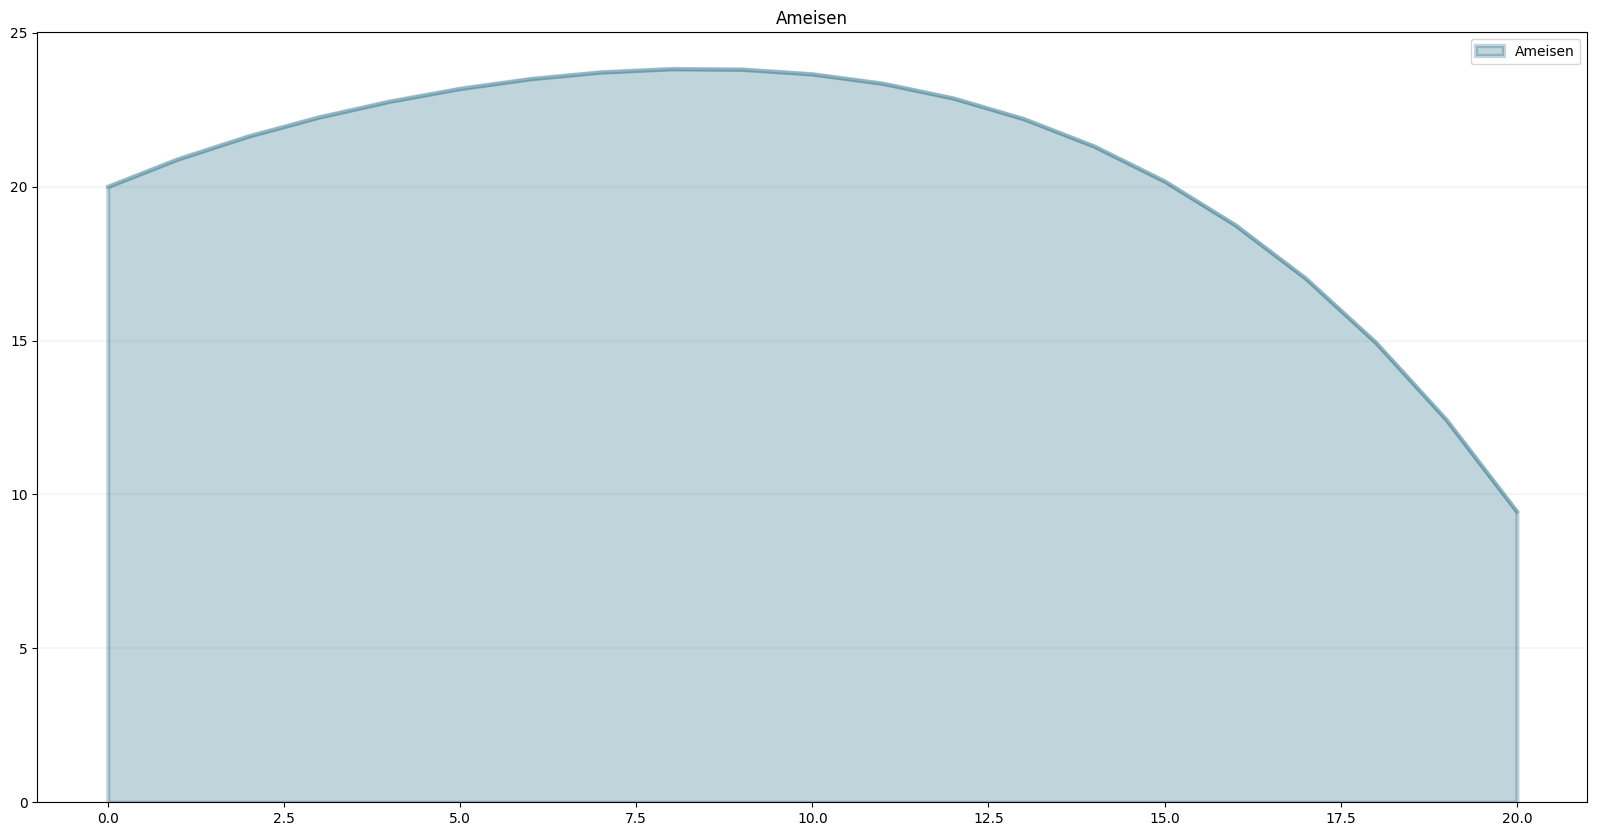

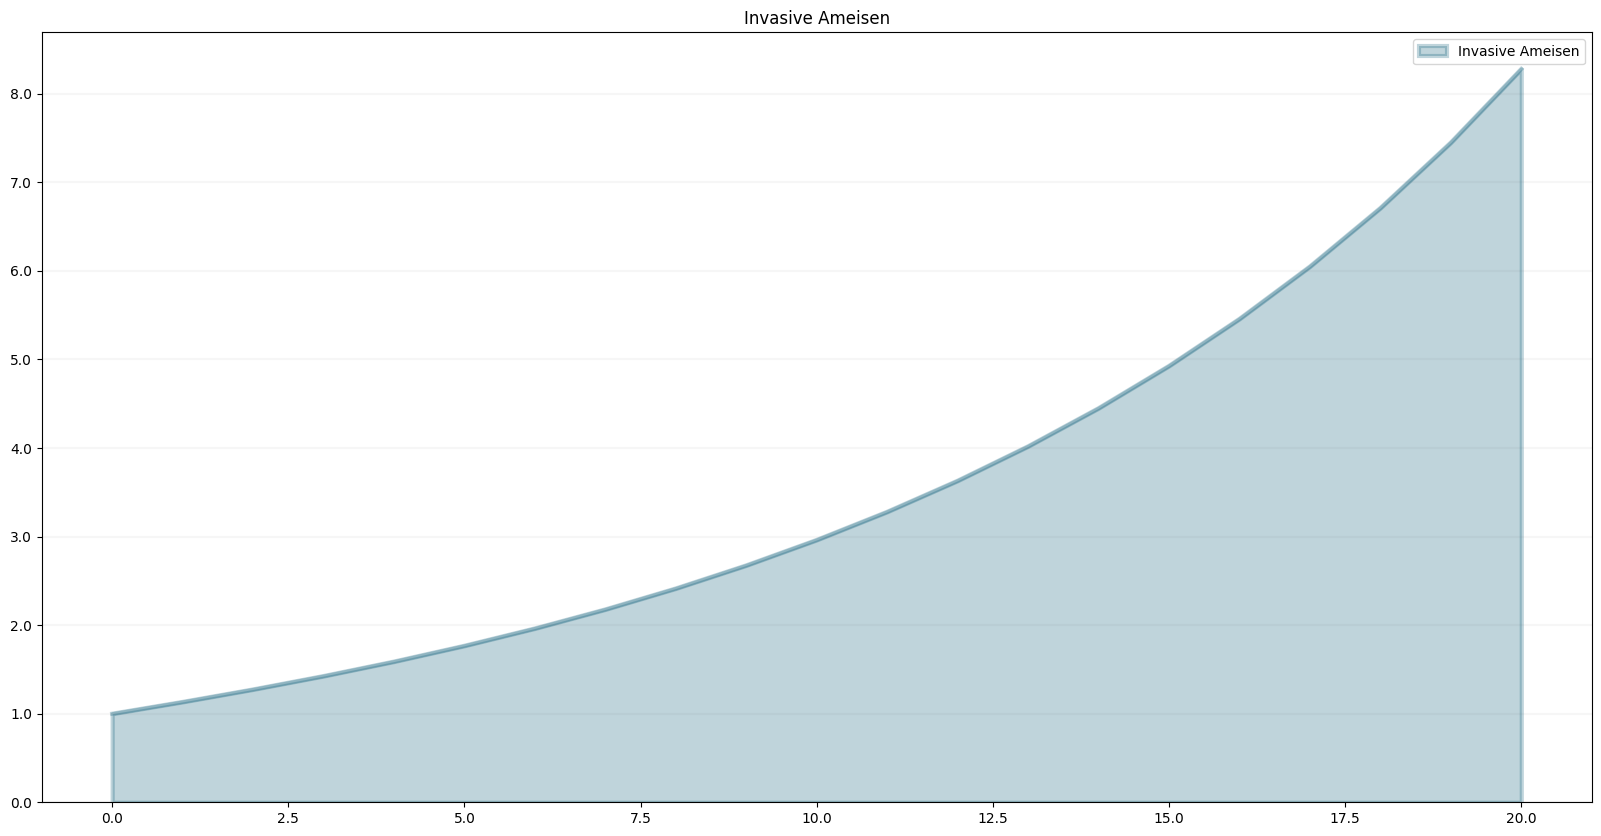

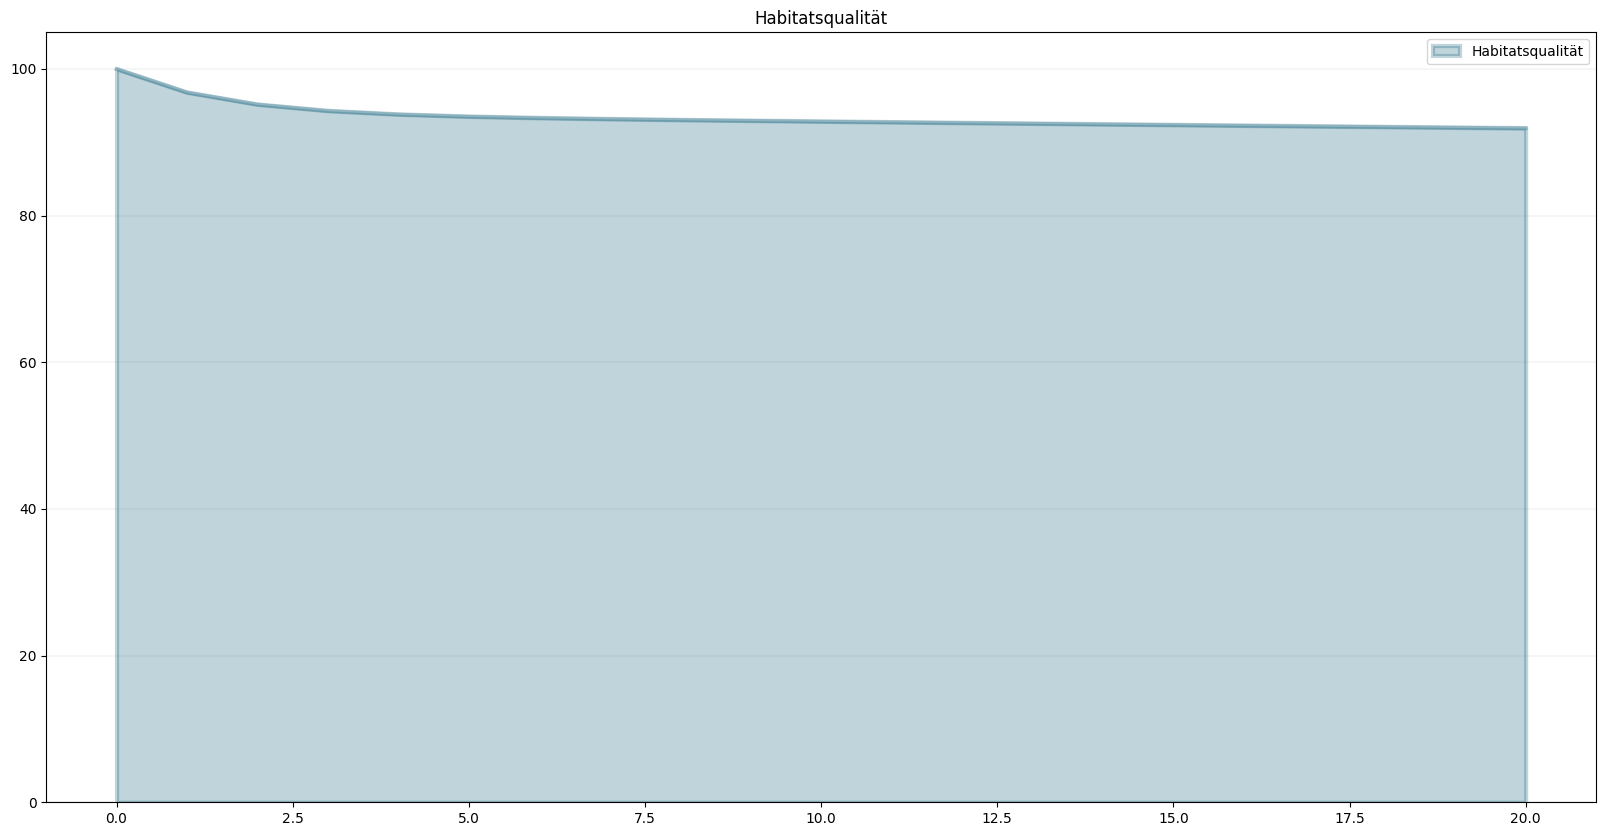

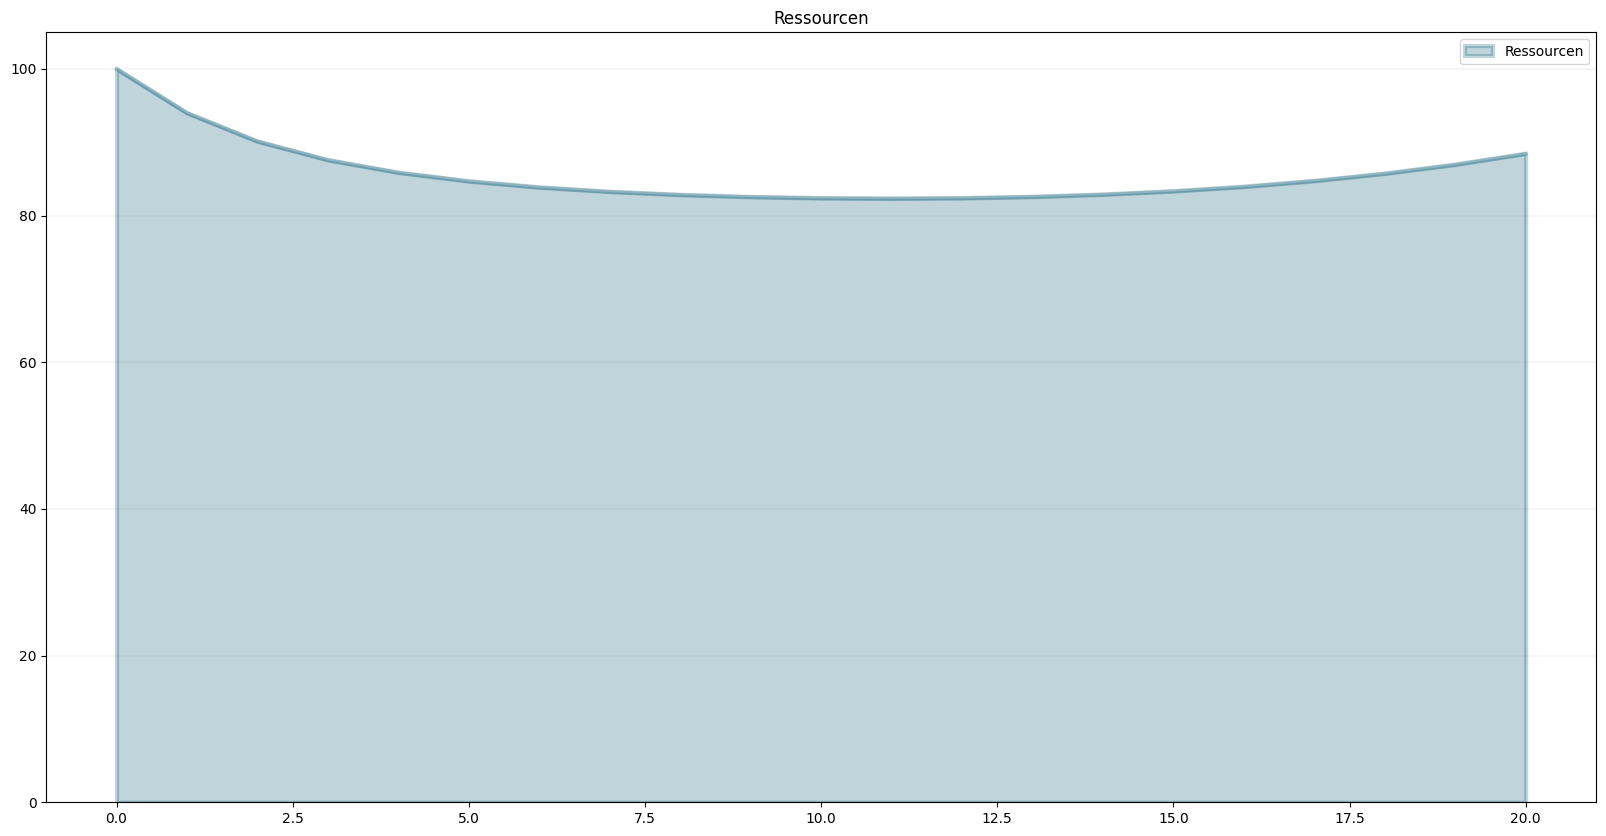

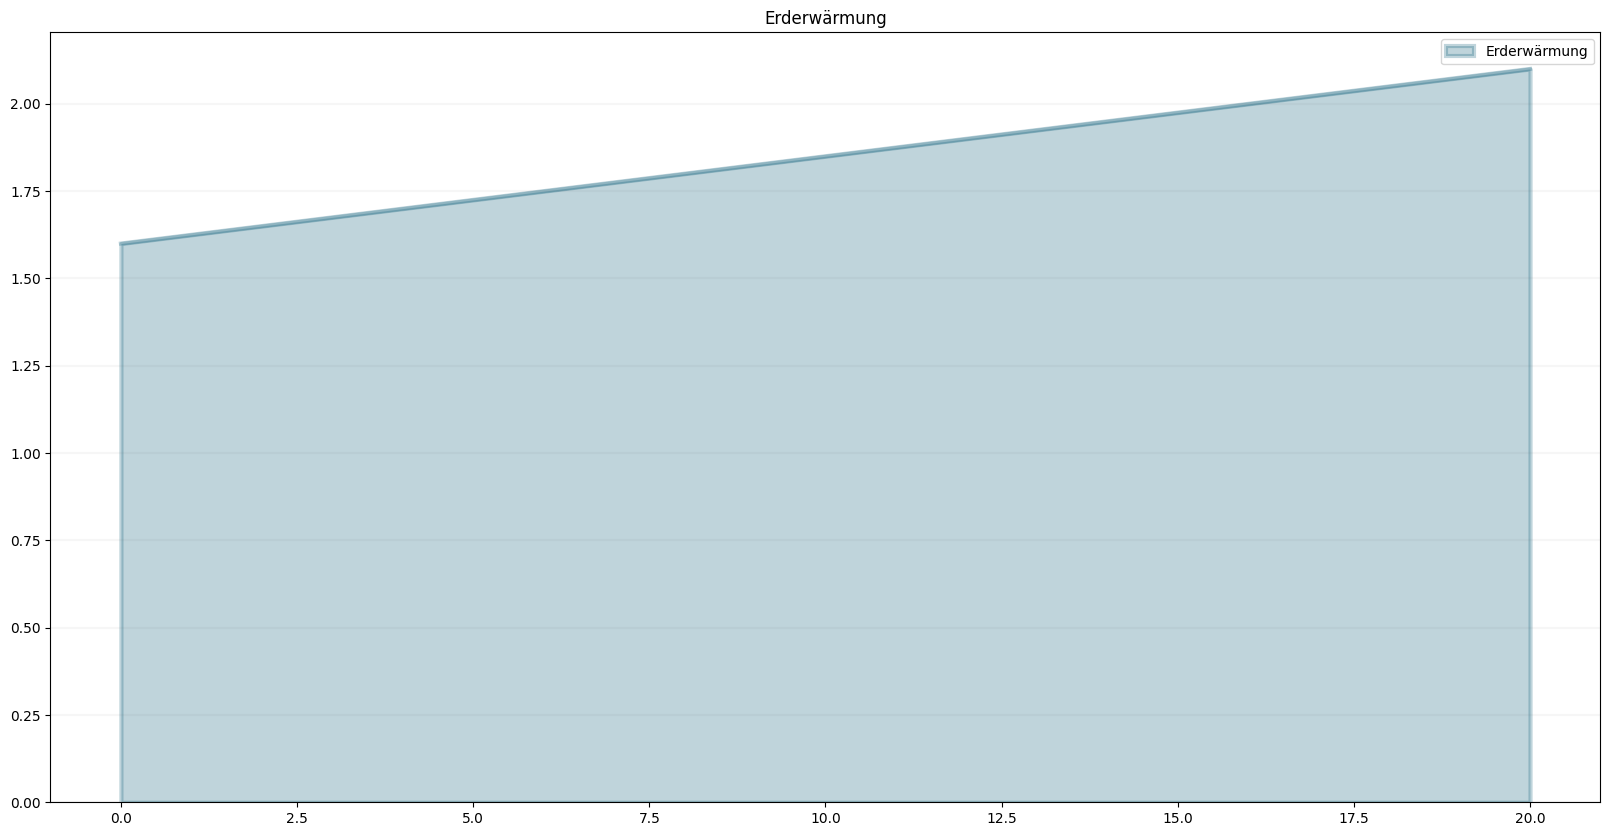

In [7]:
ant_colonies.plot()
invasive.plot()
habitat.plot()
resources.plot()
climate_change.plot()

In [8]:
bptk = bptk()

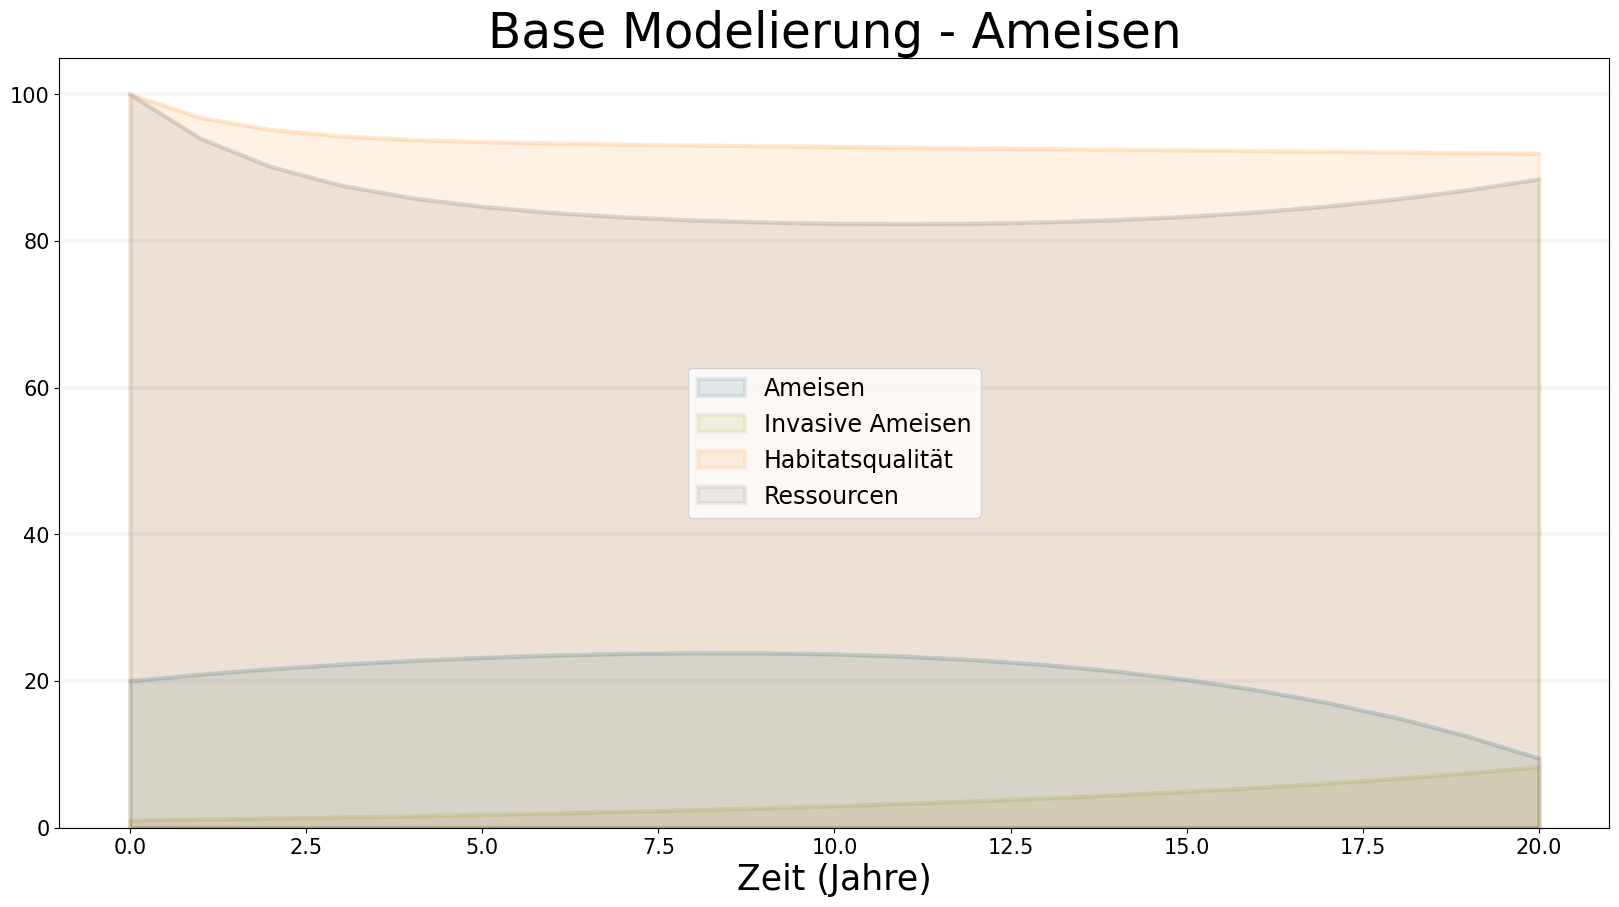

In [9]:
bptk.register_model(model)

bptk.plot_scenarios(
    scenarios="base",
    scenario_managers="smAnts",
    equations=[
        "Ameisen",
        "Invasive Ameisen",
        "Habitatsqualität",
        "Ressourcen"
    ],
    alpha=0.1,
    title="Base Modelierung - Ameisen",
    x_label="Zeit (Jahre)"
)

# LE 4: Szenarien
Verschiedener Szenarien der Veränderung der Erderwärmung im Jahr

In [10]:
scenario_manager = {
    "smAnts":{
        "model": model,
        "base_constants": {
            "ant_colonies": 20.0,
            "invasive": 1.0,
            "habitat": 100.0,
            "resources": 100.0,
            "climate_change": 1.6,
            "climate_change_increase": 0.025
        }
    }
}

bptk.register_scenario_manager(scenario_manager)

In [11]:
bptk.register_scenarios(
    scenario_manager="smAnts",
    scenarios = {
        "Erhöhung_von_0.05C": {
            "constants": {
                "Erhöhung pro Jahr": 0.05
            }
        }
    })

bptk.register_scenarios(
    scenario_manager="smAnts",
    scenarios = {
        "Erhöhung_von_0.1C": {
            "constants": {
                "Erhöhung pro Jahr": 0.1
            }
        }
    })

bptk.register_scenarios(
    scenario_manager="smAnts",
    scenarios = {
        "Erhöhung_von_0.15C": {
            "constants": {
                "Erhöhung pro Jahr": 0.15
            }
        }
    })

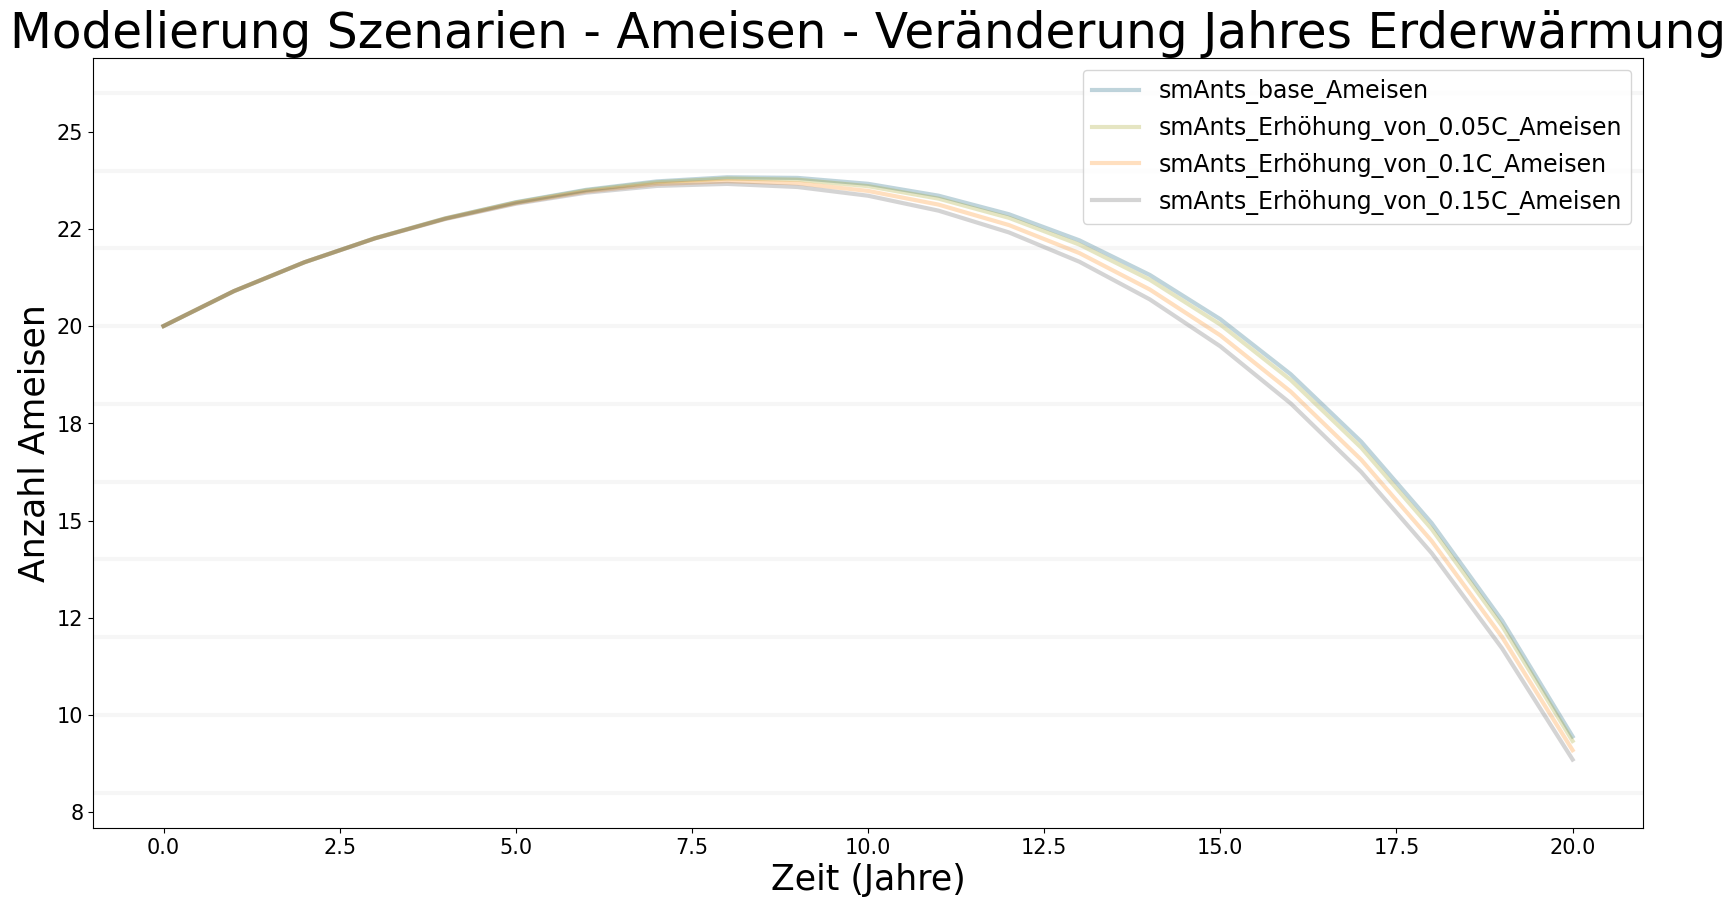

In [12]:
bptk.plot_scenarios(
    scenarios=["base", "Erhöhung_von_0.05C", "Erhöhung_von_0.1C", "Erhöhung_von_0.15C"],
    scenario_managers="smAnts",
    equations=["Ameisen"],
    series_names={},
    kind="line",
    title="Modelierung Szenarien - Ameisen - Veränderung Jahres Erderwärmung",
    x_label="Zeit (Jahre)",
    y_label="Anzahl Ameisen"
)